# **Prediction**

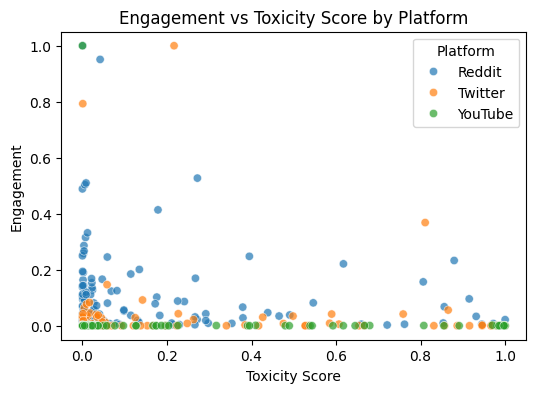

Baseline Model (mean predictor)
  MSE: 0.0381, R^2: -0.0166

Linear Regression:
  MSE: 0.0358, R^2: 0.0430
  Coefficients:
    toxicity_score: -0.0323
    word_count: 0.0130
    negative_word_count: 0.0808
    Platform_Twitter: -0.0673
    Platform_YouTube: -0.0833
  Intercept: 0.09637024196187643
--------------------------------------------------
Ridge Regression:
  MSE: 0.0357, R^2: 0.0459
  Coefficients:
    toxicity_score: -0.0300
    word_count: 0.0066
    negative_word_count: 0.0641
    Platform_Twitter: -0.0622
    Platform_YouTube: -0.0798
  Intercept: 0.0949126251647035
--------------------------------------------------
Decision Tree:
  MSE: 0.0363, R^2: 0.0308
  Intercept: N/A
--------------------------------------------------
Best-performing model: Ridge Regression (based on lowest MSE)


In [ ]:
# -------------------------------
# Prediction: Engagement vs Toxicity and Other Features
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load cleaned datasets
reddit_df  = pd.read_csv("reddit_cleaned.csv")
twitter_df = pd.read_csv("twitter_cleaned.csv")
youtube_df = pd.read_csv("youtube_cleaned.csv")

# Step 2: Select relevant columns
cols_needed = ["Platform", "Engagement", "toxicity_score", "word_count", "negative_word_count"]

reddit_mod  = reddit_df[cols_needed].copy()
twitter_mod = twitter_df[cols_needed].copy()
youtube_mod = youtube_df[cols_needed].copy()

# Combine all platforms into one dataframe
df_all = pd.concat([reddit_mod, twitter_mod, youtube_mod], ignore_index=True)

# Ensure Engagement is numeric and drop missing values
df_all["Engagement"] = pd.to_numeric(df_all["Engagement"], errors="coerce")
df_all = df_all.dropna(subset=["Engagement", "toxicity_score", "word_count", "negative_word_count"])

# Step 3: Scatterplot Engagement vs Toxicity
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_all, x="toxicity_score", y="Engagement", hue="Platform", alpha=0.7)
plt.title("Engagement vs Toxicity Score by Platform")
plt.xlabel("Toxicity Score")
plt.ylabel("Engagement")
plt.show()

# Step 4: Create dummy variables for Platform
df_model = pd.get_dummies(df_all, columns=["Platform"], drop_first=True)

# Step 5: Define features and target
feature_cols = ["toxicity_score", "word_count", "negative_word_count", "Platform_Twitter", "Platform_YouTube"]
X = df_model[feature_cols]
y = df_model["Engagement"]

# Step 6: Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Baseline Model (predict mean of training set)
baseline_pred = np.repeat(y_train.mean(), len(y_test))
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_r2  = r2_score(y_test, baseline_pred)

print("Baseline Model (mean predictor)")
print(f"  MSE: {baseline_mse:.4f}, R^2: {baseline_r2:.4f}\n")

# Step 8: Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42)
}

# Step 9: Train, predict, and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "R2": r2}

    print(f"{name}:")
    print(f"  MSE: {mse:.4f}, R^2: {r2:.4f}")
    if hasattr(model, "coef_"):
        print("  Coefficients:")
        for f, c in zip(feature_cols, model.coef_):
            print(f"    {f}: {c:.4f}")
    print(f"  Intercept: {model.intercept_ if hasattr(model, 'intercept_') else 'N/A'}")
    print("-"*50)

# Step 10: Determine best-performing model based on lowest MSE
best_model_name = min(results, key=lambda k: results[k]["MSE"])
print(f"Best-performing model: {best_model_name} (based on lowest MSE)")